# Plot linear trends in precipitation, minimum and maximum temperatures by season

# 1. Import required Python libraries

In [1]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import LC_Grid_Labels as lc
import cartopy
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
import wrf
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import IPython

## 1. a.  Print session and library version numbers

In [2]:
# Print IPython Session Info
print(IPython.sys_info())

# Print versions of libraries used in this notebook for traceability
print("\nPackage version numbers:\n")
print("xarray version: " + xr.__version__)
print("numpy version: " + np.__version__)
print("scipy version: " + scipy.__version__)
print("matplotlib version: " + matplotlib.__version__)
print("cartopy: " + cartopy.__version__)
print("wrf-python version: " + wrf.__version__+"\n")

{'commit_hash': '8c47bbcb3',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/Users/lejoflores/miniconda3/lib/python3.7/site-packages/IPython',
 'ipython_version': '7.5.0',
 'os_name': 'posix',
 'platform': 'Darwin-18.7.0-x86_64-i386-64bit',
 'sys_executable': '/Users/lejoflores/miniconda3/bin/python',
 'sys_platform': 'darwin',
 'sys_version': '3.7.3 (default, Mar 27 2019, 16:54:48) \n'
                '[Clang 4.0.1 (tags/RELEASE_401/final)]'}

Package version numbers:

xarray version: 0.13.0
numpy version: 1.17.2
scipy version: 1.2.1
matplotlib version: 3.0.3
cartopy: 0.17.0
wrf-python version: 1.3.2



# 2. Read in data using ```xarray```

In [3]:
wrf_dir = '/Users/lejoflores/data/WRF-CFS-1km-Daily/'

ds_wrf = xr.open_mfdataset(wrf_dir+'DAILY-20YR-WY-*.nc',combine='by_coords')
ds_wrf

<xarray.Dataset>
Dimensions:  (XTIME: 7305, south_north: 327, west_east: 348)
Coordinates:
  * XTIME    (XTIME) datetime64[ns] 1993-10-01 1993-10-02 ... 2013-09-30
Dimensions without coordinates: south_north, west_east
Data variables:
    DPRCP    (XTIME, south_north, west_east) float64 dask.array<chunksize=(365, 327, 348), meta=np.ndarray>
    TMEAN    (XTIME, south_north, west_east) float32 dask.array<chunksize=(365, 327, 348), meta=np.ndarray>
    Q2       (XTIME, south_north, west_east) float32 dask.array<chunksize=(365, 327, 348), meta=np.ndarray>
    SWDOWN   (XTIME, south_north, west_east) float32 dask.array<chunksize=(365, 327, 348), meta=np.ndarray>
    SWNORM   (XTIME, south_north, west_east) float32 dask.array<chunksize=(365, 327, 348), meta=np.ndarray>
    TMIN     (XTIME, south_north, west_east) float32 dask.array<chunksize=(365, 327, 348), meta=np.ndarray>
    TMAX     (XTIME, south_north, west_east) float32 dask.array<chunksize=(365, 327, 348), meta=np.ndarray>

## 2. a. Create a month of the water year array to use as a grouping variable

In [4]:
WY1 = (ds_wrf['XTIME.year'].where(ds_wrf['XTIME.month'] >= 10).values + 1)
WY2 = (ds_wrf['XTIME.year'].where(ds_wrf['XTIME.month'] < 10).values)
WY = np.nansum(np.column_stack((WY1,WY2)),axis=1)

WY_MO = ds_wrf['XTIME.month'].values - 9
WY_MO[WY_MO<=0] += 12

## 2. b. Add the month of water year array to the dataset

In [5]:
ds_wrf.coords['WY'] = xr.DataArray(WY.astype(int),dims='XTIME')
ds_wrf.coords['WY_MO'] = xr.DataArray(WY_MO.astype(int),dims='XTIME')
ds_wrf

<xarray.Dataset>
Dimensions:  (XTIME: 7305, south_north: 327, west_east: 348)
Coordinates:
  * XTIME    (XTIME) datetime64[ns] 1993-10-01 1993-10-02 ... 2013-09-30
    WY       (XTIME) int64 1994 1994 1994 1994 1994 ... 2013 2013 2013 2013 2013
    WY_MO    (XTIME) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12
Dimensions without coordinates: south_north, west_east
Data variables:
    DPRCP    (XTIME, south_north, west_east) float64 dask.array<chunksize=(365, 327, 348), meta=np.ndarray>
    TMEAN    (XTIME, south_north, west_east) float32 dask.array<chunksize=(365, 327, 348), meta=np.ndarray>
    Q2       (XTIME, south_north, west_east) float32 dask.array<chunksize=(365, 327, 348), meta=np.ndarray>
    SWDOWN   (XTIME, south_north, west_east) float32 dask.array<chunksize=(365, 327, 348), meta=np.ndarray>
    SWNORM   (XTIME, south_north, west_east) float32 dask.array<chunksize=(365, 327, 348), meta=np.ndarray>
    TMIN     (XTIME, south_north, west_east) float32 dask.array

# 3. Plot seasonal precipitation, minimum temperature, maximum temperature
## 3. a.

In [6]:
dprcp_OND = ds_wrf.DPRCP[ds_wrf.WY_MO.values<=3].groupby('WY').sum(dim='XTIME')
dprcp_JFM = ds_wrf.DPRCP[(ds_wrf.WY_MO.values > 3) & (ds_wrf.WY_MO.values <= 6)].groupby('WY').sum(dim='XTIME')
dprcp_AMJ = ds_wrf.DPRCP[(ds_wrf.WY_MO.values > 6) & (ds_wrf.WY_MO.values <= 9)].groupby('WY').sum(dim='XTIME')
dprcp_JAS = ds_wrf.DPRCP[ds_wrf.WY_MO.values > 9].groupby('WY').sum(dim='XTIME')

tmin_OND = ds_wrf.TMIN[ds_wrf.WY_MO.values<=3].groupby('WY').mean(dim='XTIME')
tmin_JFM = ds_wrf.TMIN[(ds_wrf.WY_MO.values > 3) & (ds_wrf.WY_MO.values <= 6)].groupby('WY').mean(dim='XTIME')
tmin_AMJ = ds_wrf.TMIN[(ds_wrf.WY_MO.values > 6) & (ds_wrf.WY_MO.values <= 9)].groupby('WY').mean(dim='XTIME')
tmin_JAS = ds_wrf.TMIN[ds_wrf.WY_MO.values > 9].groupby('WY').mean(dim='XTIME')

tmax_OND = ds_wrf.TMAX[ds_wrf.WY_MO.values<=3].groupby('WY').mean(dim='XTIME')
tmax_JFM = ds_wrf.TMAX[(ds_wrf.WY_MO.values > 3) & (ds_wrf.WY_MO.values <= 6)].groupby('WY').mean(dim='XTIME')
tmax_AMJ = ds_wrf.TMAX[(ds_wrf.WY_MO.values > 6) & (ds_wrf.WY_MO.values <= 9)].groupby('WY').mean(dim='XTIME')
tmax_JAS = ds_wrf.TMAX[ds_wrf.WY_MO.values > 9].groupby('WY').mean(dim='XTIME')

## 3.  b.

In [7]:
ds_wrfgeo = xr.open_dataset(wrf_dir+'wrf_geoinfo.nc')
nc_wrfgeo = nc.Dataset(wrf_dir+'wrf_geoinfo.nc')
cart_proj = get_cartopy(wrfin=nc_wrfgeo)

lats, lons = latlon_coords(ds_wrfgeo)

lat = lats[0]
lon = lons[0]

states = NaturalEarthFeature(category='cultural', scale='10m',facecolor='none',name='admin_1_states_provinces_shp')
rivers = NaturalEarthFeature(category='physical',scale='10m',facecolor='none',name='rivers_lake_centerlines')

plt.rcParams.update({'font.size': 12, 'font.family':'sans-serif'})

xticks = [-118,-117,-116,-115,-114,-113]
yticks = [42,43,44,45,46]

fig_ids = ['(a) OND','(b) JFM',
           '(c) AMJ','(d) JAS']

figsize_in = (13,13)
figres_dpi = 300
figext = '.tif'

contour_levels = 15

PrcpTrend_fname = 'fig/11_PrcpTrend'+figext
TminTrend_fname = 'fig/12_TminTrend'+figext
TmaxTrend_fname = 'fig/13_TmaxTrend'+figext

## 3. c. Get and plot 20 year linear trends in seasonal precipitation

In [8]:
south_north  = dprcp_OND.south_north
west_east  = dprcp_OND.west_east
wy = dprcp_OND.WY

seasons = np.linspace(1,4,4,dtype=np.int64)

data = np.nan*np.ones((seasons.size,south_north.size,west_east.size))

da_dprcp_trends = xr.DataArray(data,coords=[seasons,south_north,west_east],dims=['season','south_north','west_east'])

In [9]:
X = wy

for i in np.arange(seasons.size):
    
    if(i==0):
        Y = dprcp_OND.values
    elif(i==1):
        Y = dprcp_JFM.values
    elif(i==2):
        Y = dprcp_AMJ.values
    elif(i==3):
        Y = dprcp_JAS.values
    
    Y2 = Y.reshape(len(X),-1)
    # Do a first-degree polyfit
    regressions = np.polyfit(X, Y2, 1)
    # Get the coefficients back
    trends = regressions[0,:].reshape(Y.shape[1],Y.shape[2])
    
    da_dprcp_trends[i] = trends
    

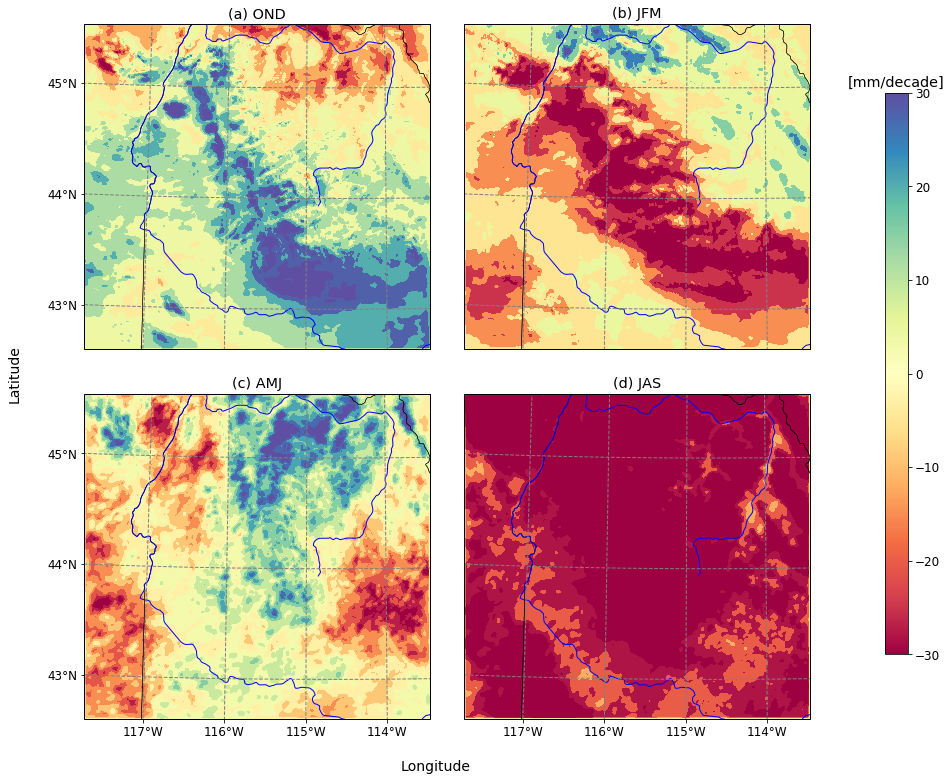

In [10]:
vmin_prcp = -30.0
vmax_prcp = 30.0

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=figsize_in, subplot_kw = {'projection': cart_proj})
fig.subplots_adjust(wspace = .1, hspace = .1)

im11 = axes[0][0].contourf(to_np(lon),to_np(lat),da_dprcp_trends[0]*10.0,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_prcp,vmax=vmax_prcp,cmap='Spectral')
im12 = axes[0][1].contourf(to_np(lon),to_np(lat),da_dprcp_trends[1]*10.0,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_prcp,vmax=vmax_prcp,cmap='Spectral')
im21 = axes[1][0].contourf(to_np(lon),to_np(lat),da_dprcp_trends[2]*10.0,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_prcp,vmax=vmax_prcp,cmap='Spectral')
im22 = axes[1][1].contourf(to_np(lon),to_np(lat),da_dprcp_trends[3]*10.0,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_prcp,vmax=vmax_prcp,cmap='Spectral')

FigIter = 0
for ax in axes.flat:
    ax.add_feature(states, linewidth=0.5, edgecolor='black')
    ax.add_feature(rivers, linewidth=1.0, edgecolor='b')
    fig.canvas.draw()
    ax.gridlines(xlocs=xticks, ylocs=yticks, color='gray', linestyle='--', linewidth=1)
    ax.set_title(fig_ids[FigIter])
    
    if(ax.rowNum==1):
        ax.xaxis.set_major_formatter(lc.LONGITUDE_FORMATTER) 
        lc.lambert_xticks(ax, xticks)
    
    if(ax.colNum==0):
        ax.yaxis.set_major_formatter(lc.LATITUDE_FORMATTER)
        lc.lambert_yticks(ax, yticks)

    FigIter += 1
    
fig.text(0.5, 0.08, 'Longitude', ha='center', va='center', fontsize=14)
fig.text(0.05, 0.5, 'Latitude', ha='center', va='center', rotation='vertical', fontsize=14)

cbar_ax = fig.add_axes([0.98, 0.2, 0.025, 0.6],in_layout=False)

m = plt.cm.ScalarMappable(cmap=cm.Spectral)
m.set_array(to_np(da_dprcp_trends[0]*10.0))
m.set_clim(vmin_prcp, vmax_prcp)
clb = fig.colorbar(m,cax = cbar_ax)
clb.ax.set_title('[mm/decade]')

plt.savefig(PrcpTrend_fname, dpi=figres_dpi, facecolor='w', edgecolor='w', 
            orientation='portrait', bbox_inches='tight')
plt.show()

## 3. d. Get and plot 20 year linear trends in seasonal minimum temperature

In [11]:
south_north  = tmin_OND.south_north
west_east  = tmin_OND.west_east
wy = tmin_OND.WY

seasons = np.linspace(1,4,4,dtype=np.int64)

data = np.nan*np.ones((seasons.size,south_north.size,west_east.size))

da_tmin_trends = xr.DataArray(data,coords=[seasons,south_north,west_east],dims=['season','south_north','west_east'])

In [12]:
X = wy

for i in np.arange(seasons.size):
    
    if(i==0):
        Y = tmin_OND.values
    elif(i==1):
        Y = tmin_JFM.values
    elif(i==2):
        Y = tmin_AMJ.values
    elif(i==3):
        Y = tmin_JAS.values
    
    Y2 = Y.reshape(len(X),-1)
    # Do a first-degree polyfit
    regressions = np.polyfit(X, Y2, 1)
    # Get the coefficients back
    trends = regressions[0,:].reshape(Y.shape[1],Y.shape[2])
    
    da_tmin_trends[i] = trends
    

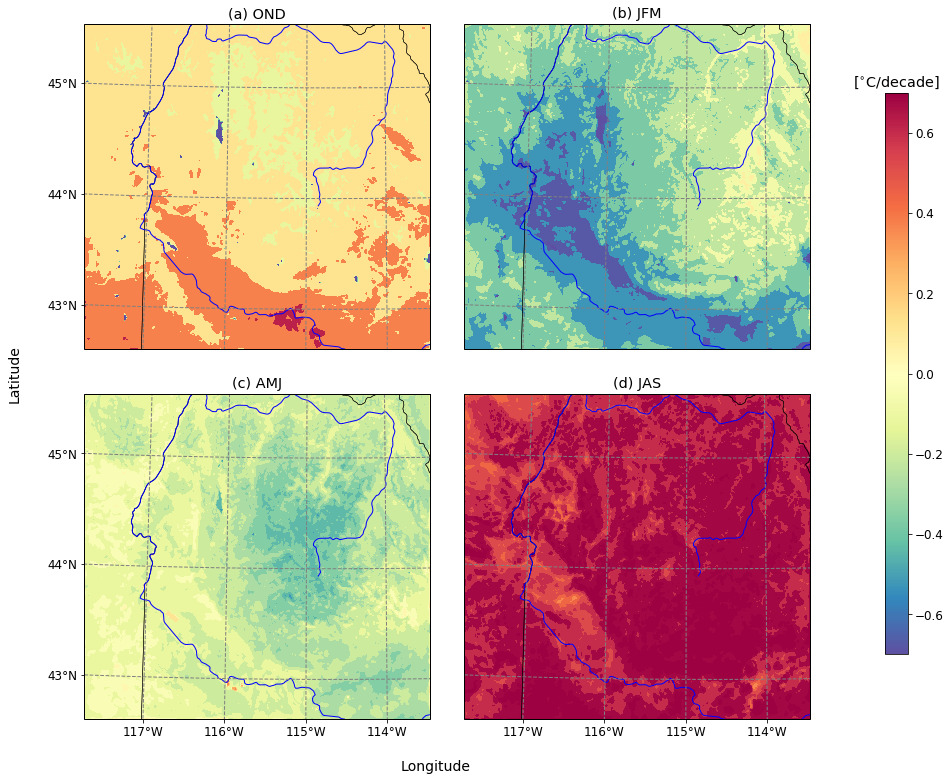

In [13]:
vmin_tmin = -0.7
vmax_tmin = 0.7

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=figsize_in, subplot_kw = {'projection': cart_proj})
fig.subplots_adjust(wspace = .1, hspace = .1)

im11 = axes[0][0].contourf(to_np(lon),to_np(lat),da_tmin_trends[0]*10.0,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_tmin,vmax=vmax_tmin,cmap='Spectral_r')
im12 = axes[0][1].contourf(to_np(lon),to_np(lat),da_tmin_trends[1]*10.0,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_tmin,vmax=vmax_tmin,cmap='Spectral_r')
im21 = axes[1][0].contourf(to_np(lon),to_np(lat),da_tmin_trends[2]*10.0,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_tmin,vmax=vmax_tmin,cmap='Spectral_r')
im22 = axes[1][1].contourf(to_np(lon),to_np(lat),da_tmin_trends[3]*10.0,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_tmin,vmax=vmax_tmin,cmap='Spectral_r')

FigIter = 0
for ax in axes.flat:
    ax.add_feature(states, linewidth=0.5, edgecolor='black')
    ax.add_feature(rivers, linewidth=1.0, edgecolor='b')
    fig.canvas.draw()
    ax.gridlines(xlocs=xticks, ylocs=yticks, color='gray', linestyle='--', linewidth=1)
    ax.set_title(fig_ids[FigIter])
    
    if(ax.rowNum==1):
        ax.xaxis.set_major_formatter(lc.LONGITUDE_FORMATTER) 
        lc.lambert_xticks(ax, xticks)
    
    if(ax.colNum==0):
        ax.yaxis.set_major_formatter(lc.LATITUDE_FORMATTER)
        lc.lambert_yticks(ax, yticks)

    FigIter += 1
    
fig.text(0.5, 0.08, 'Longitude', ha='center', va='center', fontsize=14)
fig.text(0.05, 0.5, 'Latitude', ha='center', va='center', rotation='vertical', fontsize=14)

cbar_ax = fig.add_axes([0.98, 0.2, 0.025, 0.6],in_layout=False)

m = plt.cm.ScalarMappable(cmap=cm.Spectral_r)
m.set_array(to_np(da_tmin_trends[0]*10.0))
m.set_clim(vmin_tmin, vmax_tmin)
clb = fig.colorbar(m,cax = cbar_ax)
clb.ax.set_title('[${}^{\circ}$C/decade]')

plt.savefig(TminTrend_fname, dpi=figres_dpi, facecolor='w', edgecolor='w', 
            orientation='portrait', bbox_inches='tight')
plt.show()

## 3. e. Get and plot 20 year linear trends in seasonal maximum temperature

In [14]:
south_north  = tmax_OND.south_north
west_east  = tmax_OND.west_east
wy = tmax_OND.WY

seasons = np.linspace(1,4,4,dtype=np.int64)

data = np.nan*np.ones((seasons.size,south_north.size,west_east.size))

da_tmax_trends = xr.DataArray(data,coords=[seasons,south_north,west_east],dims=['season','south_north','west_east'])

In [15]:
X = wy

for i in np.arange(seasons.size):
    
    if(i==0):
        Y = tmax_OND.values
    elif(i==1):
        Y = tmax_JFM.values
    elif(i==2):
        Y = tmax_AMJ.values
    elif(i==3):
        Y = tmax_JAS.values
    
    Y2 = Y.reshape(len(X),-1)
    # Do a first-degree polyfit
    regressions = np.polyfit(X, Y2, 1)
    # Get the coefficients back
    trends = regressions[0,:].reshape(Y.shape[1],Y.shape[2])
    
    da_tmax_trends[i] = trends
    

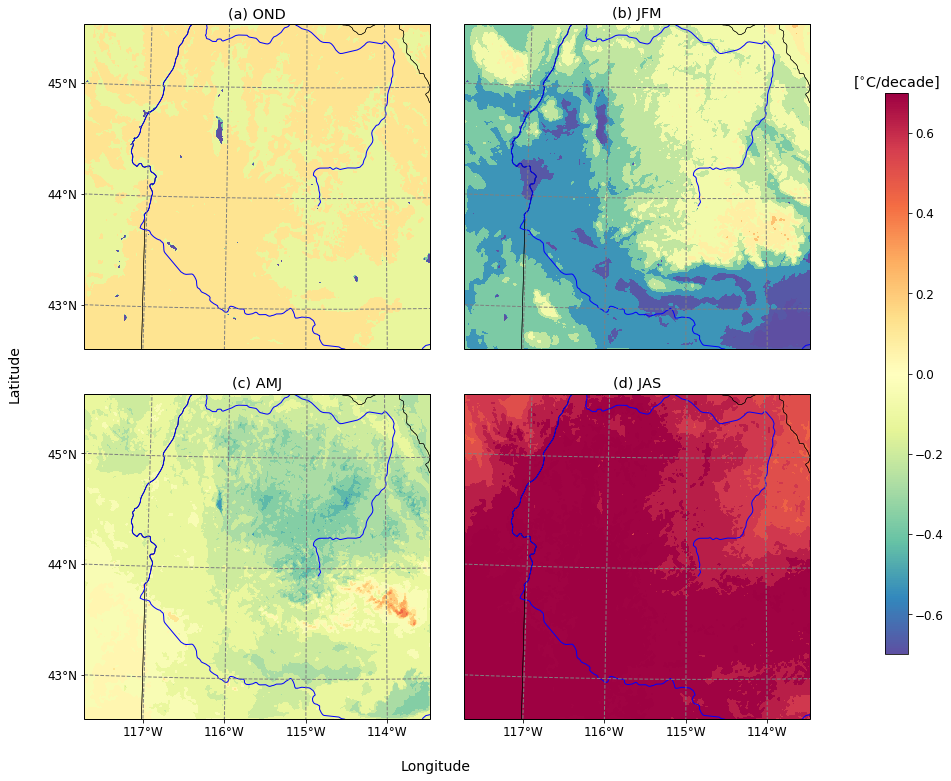

In [16]:
vmin_tmax = -0.7
vmax_tmax = 0.7

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=figsize_in, subplot_kw = {'projection': cart_proj})
fig.subplots_adjust(wspace = .1, hspace = .1)

im11 = axes[0][0].contourf(to_np(lon),to_np(lat),da_tmax_trends[0]*10.0,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_tmax,vmax=vmax_tmax,cmap='Spectral_r')
im12 = axes[0][1].contourf(to_np(lon),to_np(lat),da_tmax_trends[1]*10.0,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_tmax,vmax=vmax_tmax,cmap='Spectral_r')
im21 = axes[1][0].contourf(to_np(lon),to_np(lat),da_tmax_trends[2]*10.0,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_tmax,vmax=vmax_tmax,cmap='Spectral_r')
im22 = axes[1][1].contourf(to_np(lon),to_np(lat),da_tmax_trends[3]*10.0,contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_tmax,vmax=vmax_tmax,cmap='Spectral_r')

FigIter = 0
for ax in axes.flat:
    ax.add_feature(states, linewidth=0.5, edgecolor='black')
    ax.add_feature(rivers, linewidth=1.0, edgecolor='b')
    fig.canvas.draw()
    ax.gridlines(xlocs=xticks, ylocs=yticks, color='gray', linestyle='--', linewidth=1)
    ax.set_title(fig_ids[FigIter])
    
    if(ax.rowNum==1):
        ax.xaxis.set_major_formatter(lc.LONGITUDE_FORMATTER) 
        lc.lambert_xticks(ax, xticks)
    
    if(ax.colNum==0):
        ax.yaxis.set_major_formatter(lc.LATITUDE_FORMATTER)
        lc.lambert_yticks(ax, yticks)

    FigIter += 1
    
fig.text(0.5, 0.08, 'Longitude', ha='center', va='center', fontsize=14)
fig.text(0.05, 0.5, 'Latitude', ha='center', va='center', rotation='vertical', fontsize=14)

cbar_ax = fig.add_axes([0.98, 0.2, 0.025, 0.6],in_layout=False)

m = plt.cm.ScalarMappable(cmap=cm.Spectral_r)
m.set_array(to_np(da_tmax_trends[0]*10.0))
m.set_clim(vmin_tmax, vmax_tmax)
clb = fig.colorbar(m,cax = cbar_ax)
clb.ax.set_title('[${}^{\circ}$C/decade]')

plt.savefig(TmaxTrend_fname, dpi=figres_dpi, facecolor='w', edgecolor='w', 
            orientation='portrait', bbox_inches='tight')
plt.show()